# Project 3 - 02 : Models

## Settings

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# install requirements
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 KB 4.1 MB/s eta 0:00:00


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.impute import KNNImputer
from sklearn import linear_model, svm, neural_network, ensemble
from xgboost import XGBRegressor, plot_importance

import joblib

# random seed
SEED = 0

# paths
PROJECT_ROOT = '/content/drive/MyDrive/Colab Notebooks/OC_IML/OC_IML_P3_elec'
DATA_DIR = os.path.join(PROJECT_ROOT, 'Pelec_04_data')
MODELS_DIR = os.path.join(DATA_DIR, 'models')
# set project root as working directory
%cd $PROJECT_ROOT


# pandas
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)
pd.options.display.max_colwidth = 500

# plotly
plotly_base_params = {
    'template': "plotly_white",
    'title_font': dict(size=29, color='#8a8d93', family="Lato, sans-serif"),
    'font': dict(color='#424242'), 
    'hoverlabel': dict(bgcolor="#f2f2f2", font_size=13, font_family="Lato, sans-serif")
}



/content/drive/MyDrive/Colab Notebooks/OC_IML/OC_IML_P3_elec


In [4]:
data = pd.read_csv(os.path.join(DATA_DIR, 'cleaned_data.csv'), sep=',', index_col='OSEBuildingID',
                   dtype={'BuildingType': 'category',
                          'PrimaryPropertyType': 'category',
                          'SecondLargestPropertyUseType': 'category',
                          'ThirdLargestPropertyUseType': 'category',
                          'ComplianceStatus': 'category'})
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1611 entries, 1 to 50226
Data columns (total 23 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   BuildingType                    1611 non-null   category
 1   PrimaryPropertyType             1611 non-null   category
 2   NumberofBuildings               1611 non-null   float64 
 3   NumberofFloors                  1606 non-null   float64 
 4   PropertyGFATotal                1611 non-null   int64   
 5   PropertyGFAParking              1611 non-null   int64   
 6   LargestPropertyUseType          1609 non-null   object  
 7   SecondLargestPropertyUseType    1609 non-null   category
 8   ThirdLargestPropertyUseType     1610 non-null   category
 9   ENERGYSTARScore                 1075 non-null   float64 
 10  SiteEnergyUse_kBtu              1611 non-null   float64 
 11  GHG_emissions_TCO2e             1611 non-null   float64 
 12  ComplianceStatus   

## Preprocessing

**Categorical features encoding**:  
The [`pd.get_dummies()`](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html) method automatically detects the categorical columns to apply a OneHot encoding.
It's also removing a category for each featureto avoid problems caused by perfectly collinear columns.

In [5]:
# store encoded buildingTypes to stratify splits
encoded_btypes = LabelEncoder().fit_transform(data.BuildingType)

# OneHot encoding of categorical features
data_enc = pd.get_dummies(
    data,
    prefix_sep='_', # separator between prefix and category
    dummy_na=False, # if na are used as a category
    columns=None, # if none selet object and category dtypes
    drop_first=True, # drop first column
    dtype=None  # output dtype
)

**Data split**:  
80/20 train/test split stratified on buildingTypes and extraction of the target features.



In [6]:
# 80/20 stratified train/test split
train, test = train_test_split(data_enc, test_size=0.2, shuffle=True, stratify=encoded_btypes)

# X/y split
# train
y_train_true_co2 = train.pop('GHG_emissions_TCO2e')
y_train_true_nrg = train.pop('SiteEnergyUse_kBtu')
# test
y_test_true_co2 = test.pop('GHG_emissions_TCO2e')
y_test_true_nrg = test.pop('SiteEnergyUse_kBtu')

**Target transformation**:  
The logarithmic function `np.log1p()` is used to linearize the targets, allowing better prediction even with a similar linear model. The exponential function `np.exp1m()` inverse the tsanformmation.  
[Effect of transforming the targets in regression model](https://scikit-learn.org/stable/auto_examples/compose/plot_transformed_target.html)

In [7]:
# Get targets log
# train
y_train_log_co2 = np.log1p(y_train_true_co2)
y_train_log_nrg = np.log1p(y_train_true_nrg)
# test
y_test_log_co2 = np.log1p(y_test_true_co2)
y_test_log_nrg = np.log1p(y_test_true_nrg)

**Feature scaling**: [MinMaxScaler doc](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)  
Normalization because the features do not have a Gaussian distribution. Scales data between 0 and 1.  

**Missing values imputation**: [KNNImputer doc](https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html)  
Using kNN algorithm as it is a robust method for imputation. (It uses the Euclidean distance to compare examples so the features must have the same range of values.)  


In [8]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, StandardScaler

preprocessor = Pipeline([
    # Categorical featurees encoding
    # Feature scaling
    ('scaler', MinMaxScaler(feature_range=(0, 1))),
    #('scaler', StandardScaler()),
    # missing values imputation
    ('imputer', KNNImputer(n_neighbors=5)),
    #('pca', PCA(n_components=20))
])

# fit/transform on the trainset and only transform the testset
X_train = pd.DataFrame(preprocessor.fit_transform(train), columns=train.columns)
X_test = pd.DataFrame(preprocessor.transform(test), columns=test.columns)

print(f"Final df - train: {X_train.shape} / test: {test.shape}")

Final df - train: (1288, 185) / test: (323, 185)


## Model building

### Models comparison

Training of multiple models with CrossValidation to find the the best one for each target.

In [9]:
models = {
    # Linear models
    #'LinearRegression': linear_model.LinearRegression(n_jobs=-1),
    'Ridge': linear_model.Ridge(solver='auto', random_state=SEED),
    'Lasso': linear_model.Lasso(random_state=SEED),
    'Elasticnet': linear_model.ElasticNet(random_state=SEED),
    'LinearSVR': svm.LinearSVR(max_iter=1e5, random_state=SEED),
    # SVM
    'SVR': svm.SVR(kernel='rbf', max_iter=10000),
    # Ensemble models
    'RandomForest': ensemble.RandomForestRegressor(n_jobs=-1, random_state=SEED),
    'XGBoost': XGBRegressor(objective='reg:squarederror', n_jobs=-1, random_state=0),
    # Neural Network
    'MLP': neural_network.MLPRegressor(
        hidden_layer_sizes=(500,),
        activation='relu', solver='adam',
        learning_rate='constant', max_iter=1000,
    )
}
eval = ['neg_root_mean_squared_error', 'r2']
cv = 10

In [10]:
def compare_models_cv(X_train, y, models:dict, cv:int, metrics:list, verbose=0):
    """Returns the mean score of each metrics applied by cross-validation to passed models"""    
    all_scores = []
    for m in models:
        if verbose:
            print(f'Training {m} ...', end=' ')
        # calculate the model scores for each y
        model = models[m]
        partial_scores = cross_validate(
            model, X_train, y, 
            cv=cv, scoring=metrics, 
            return_train_score=True,
        )
        # convert to a dataframe
        partial_scores = pd.DataFrame.from_dict(partial_scores)
        # get mean score for each metrics and pivot the dataframe
        partial_scores = partial_scores.mean().to_frame().T
        # add the model name into the df
        partial_scores['model'] = m
        # add scores to the scoreslist
        all_scores.append(partial_scores)
        if verbose:
            print('Done ✅')
    # concat all scores into a single df
    all_scores = pd.concat(all_scores, ignore_index=True).set_index('model')
    return all_scores

In [11]:
co2_scores = compare_models_cv(X_train, y_train_log_co2, models, cv, eval, verbose=1)
# neg rmse to rmse
co2_scores['test_neg_root_mean_squared_error'] = co2_scores['test_neg_root_mean_squared_error'] * -1
co2_scores['train_neg_root_mean_squared_error'] = co2_scores['train_neg_root_mean_squared_error'] * -1
co2_scores

Training Ridge ... Done ✅
Training Lasso ... Done ✅
Training Elasticnet ... Done ✅
Training LinearSVR ... Done ✅
Training SVR ... Done ✅
Training RandomForest ... Done ✅
Training XGBoost ... Done ✅
Training MLP ... Done ✅


,fit_time,score_time,test_neg_root_mean_squared_error,train_neg_root_mean_squared_error,test_r2,train_r2
model,,,,,,
Ridge,0.032,0.013,0.830,0.718,0.609,0.710
Lasso,0.028,0.012,1.333,1.334,-0.002,0.000
Elasticnet,0.018,0.008,1.333,1.334,-0.002,0.000
LinearSVR,0.061,0.012,0.858,0.738,0.582,0.694
SVR,0.297,0.072,0.845,0.719,0.595,0.709
RandomForest,3.018,0.055,0.770,0.292,0.661,0.952
XGBoost,0.768,0.006,0.721,0.580,0.705,0.811
MLP,28.451,0.010,0.867,0.315,0.572,0.944


In [12]:
nrg_scores = compare_models_cv(X_train, y_train_log_nrg, models, cv, eval, verbose=1)
nrg_scores['test_neg_root_mean_squared_error'] = nrg_scores['test_neg_root_mean_squared_error'] * -1
nrg_scores['train_neg_root_mean_squared_error'] = nrg_scores['train_neg_root_mean_squared_error'] * -1
nrg_scores

Training Ridge ... Done ✅
Training Lasso ... Done ✅
Training Elasticnet ... Done ✅
Training LinearSVR ... Done ✅
Training SVR ... Done ✅
Training RandomForest ... Done ✅
Training XGBoost ... Done ✅
Training MLP ... Done ✅


,fit_time,score_time,test_neg_root_mean_squared_error,train_neg_root_mean_squared_error,test_r2,train_r2
model,,,,,,
Ridge,0.018,0.007,0.887,0.767,0.662,0.770
Lasso,0.023,0.011,1.562,1.600,-0.006,0.000
Elasticnet,0.022,0.010,1.562,1.600,-0.006,0.000
LinearSVR,0.045,0.007,1.092,1.049,0.522,0.570
SVR,0.202,0.049,1.203,1.196,0.429,0.441
RandomForest,1.683,0.030,0.834,0.362,0.698,0.949
XGBoost,0.414,0.007,0.784,0.526,0.730,0.892
MLP,41.792,0.009,1.018,0.295,0.544,0.966


In [ ]:
x = list(models.keys())
train_clr = '#FF8019'
test_clr = '#2DB42D'
time_clr = '#5CA3F9'

# chart
fig = make_subplots(
    rows=3, cols=2,
    column_widths=[0.5, 0.5],
    horizontal_spacing=0.2, vertical_spacing=0.05,
    specs=[[{"type": "bar"}, {"type": "bar"}],
           [{"type": "bar"}, {"type": "bar"}],
           [{"type": "bar"}, {"type": "bar"}]],
           subplot_titles=("CO2 Emissions", "Energy Consumption")
)
# R2
fig.add_trace(go.Bar(x=list(models.keys()), y=co2_scores.train_r2, marker_color=train_clr, name='train'), row=1, col=1)
fig.add_trace(go.Bar(x=list(models.keys()), y=co2_scores.test_r2, marker_color=test_clr, name='test'),  row=1, col=1)
fig.add_trace(go.Bar(x=list(models.keys()), y=nrg_scores.train_r2, marker_color=train_clr, name='train'), row=1, col=2)
fig.add_trace(go.Bar(x=list(models.keys()), y=nrg_scores.test_r2, marker_color=test_clr, name='test'),  row=1, col=2)
# RMSE
fig.add_trace(go.Bar(x=list(models.keys()), y=co2_scores.train_neg_root_mean_squared_error, marker_color=train_clr, name='train'), row=2, col=1)
fig.add_trace(go.Bar(x=list(models.keys()), y=co2_scores.test_neg_root_mean_squared_error, marker_color=test_clr, name='test'),  row=2, col=1)
fig.add_trace(go.Bar(x=list(models.keys()), y=nrg_scores.train_neg_root_mean_squared_error, marker_color=train_clr, name='train'), row=2, col=2)
fig.add_trace(go.Bar(x=list(models.keys()), y=nrg_scores.test_neg_root_mean_squared_error, marker_color=test_clr, name='test'),  row=2, col=2)

# fit time
fig.add_trace(go.Bar(x=list(models.keys()), y=co2_scores.fit_time, marker_color=time_clr), row=3, col=1)
fig.add_trace(go.Bar(x=list(models.keys()), y=nrg_scores.fit_time, marker_color=time_clr), row=3, col=2)

# styling
fig.update_traces(texttemplate='%{y:.2f}', textposition='inside')
fig['layout']['yaxis']['title']='<b>R²</b>'
fig['layout']['yaxis3']['title']='<b>RMSE</b>'
fig['layout']['yaxis5']['title']='<b>Fit Time</b>'
fig.for_each_annotation(lambda a: a.update(text=f'<b>{a.text}</b>'))
fig.update_layout(width=1000, height=1000, barmode='group',title="Models Cross-Validation Comparisons",
    showlegend=False, **plotly_base_params)
fig.show()

We can notice several things on this chart:
- Linear models do not seem suitable for these predictions.
- Non-linear models perform better but require more learning time and are more subject to overfitting
- All models are overfitted
- The XGB model has the best performance of all the tested models.

### Tuning best model

To speed up the process, the optimization was done by iterations with small numbers of values per parameter.

In [14]:
%%time
from sklearn.model_selection import GridSearchCV
import joblib

xgb_params_grid = {
    'n_estimators' : [250, 300, 350],
    'max_depth': [1, 2, 4],
    'colsample_bytree': [.7, .8, .9],
    'subsample': [.6, .7, .8],
    'learning_rate': [.1,]
}
fixed_params_co2 = {
    #'learning_rate': 0.1,
    #'max_depth': 2,
    #'colsample_bytree': 0.2,
    #'subsample': .8
}

model_co2 = XGBRegressor(**fixed_params_co2, objective='reg:squarederror', n_jobs=-1, random_state=SEED)
gs_co2 = GridSearchCV(model_co2, xgb_params_grid, cv=cv, scoring='r2', return_train_score=True, n_jobs=-1)
gs_co2.fit(X_train, y_train_log_co2)
joblib.dump(gs_co2.best_estimator_, os.path.join(MODELS_DIR, "tuned_xgb_co2.pkl"))
print(f"CO2 emissions:\n > Best r²: {gs_co2.best_score_}\n > Best params: {gs_co2.best_params_}")
tuned_model_co2 = gs_co2.best_estimator_

CO2 emissions:
 > Best r²: 0.7238823944419837
 > Best params: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 350, 'subsample': 0.6}
CPU times: user 8.43 s, sys: 592 ms, total: 9.03 s
Wall time: 15min 11s


In [15]:
%%time
xgb_params_grid = {
    'n_estimators' : [250, 300, 350],
    'max_depth': [2, 4, 6,],
    'colsample_bytree': [.5, .7, .9],
    'subsample': [.8, .9, 1.],
    'learning_rate': [.1]
}
fixed_params_nrg = {
    #'n_estimator':100,
    #'learning_rate': 0.1,
    #'max_depth': 7,
    #'subsample': .8,
    #'colsample_bytree': .8,
}

model_nrg = XGBRegressor(**fixed_params_nrg, objective='reg:squarederror', n_jobs=-1, random_state=SEED)
gs_nrg = GridSearchCV(model_nrg, xgb_params_grid, cv=cv, scoring='r2', return_train_score=True, n_jobs=-1)
gs_nrg.fit(X_train, y_train_log_nrg)
joblib.dump(gs_nrg.best_estimator_, os.path.join(MODELS_DIR, "tuned_xgb_nrg.pkl"))
print(f"Energy consumption:\n > Best r²: {gs_nrg.best_score_}\n > Best params: {gs_nrg.best_params_}")
tuned_model_nrg = gs_nrg.best_estimator_

Energy consumption:
 > Best r²: 0.7529847270318573
 > Best params: {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 250, 'subsample': 0.8}
CPU times: user 9.43 s, sys: 570 ms, total: 9.99 s
Wall time: 18min 42s


### Evaluation

In [16]:
# Loads models if the environment has restarted
if not 'tuned_model_co2' in locals():
    tuned_model_co2 = joblib.load(os.path.join(MODELS_DIR, f"tuned_xgb_co2.pkl"))
    print('✅ CO2 model loaded.')
if not 'tuned_model_nrg' in locals():
    tuned_model_nrg = joblib.load(os.path.join(MODELS_DIR, f"tuned_xgb_nrg.pkl"))
    print('✅ Energy model loaded.')

tuned_models = dict(CO2=tuned_model_co2, Energy=tuned_model_nrg)

In [17]:
preds_co2_train = pd.DataFrame(tuned_model_co2.predict(X_train))
preds_co2 = pd.DataFrame(tuned_model_co2.predict(X_test))
score_co2 = {
    'train': metrics.r2_score(y_train_log_co2, preds_co2_train),
    'test': metrics.r2_score(y_test_log_co2, preds_co2)
}
print(f"Scores CO2 - train R²={score_co2['train']:.3f} / test R²={score_co2['test']:.3f}")

preds_nrg_train = pd.DataFrame(tuned_model_nrg.predict(X_train))
preds_nrg = pd.DataFrame(tuned_model_nrg.predict(X_test))
score_nrg = {
    'train':metrics.r2_score(y_train_log_nrg, preds_nrg_train),
    'test': metrics.r2_score(y_test_log_nrg, preds_nrg)
}
print(f"Scores Energy - train R²={score_nrg['train']:.3f} / test R²={score_nrg['test']:.3f}")

Scores CO2 - train R²=0.838 / test R²=0.732
Scores Energy - train R²=0.967 / test R²=0.904


In [18]:
fig = go.Figure([
    go.Bar(x=['CO2', 'Energy'], y=[score_co2['train'], score_nrg['train']], marker_color=train_clr, name='Train'),
    go.Bar(x=['CO2', 'Energy'], y=[score_co2['test'], score_nrg['test']], marker_color=test_clr, name='Test')
])
fig.update_traces(texttemplate='%{y:.2f}', textposition='inside')
fig.update_layout(width=700, height=500,
                  title="Tuned XGB on testset",
                  yaxis_title="R²", **plotly_base_params)
fig.show()

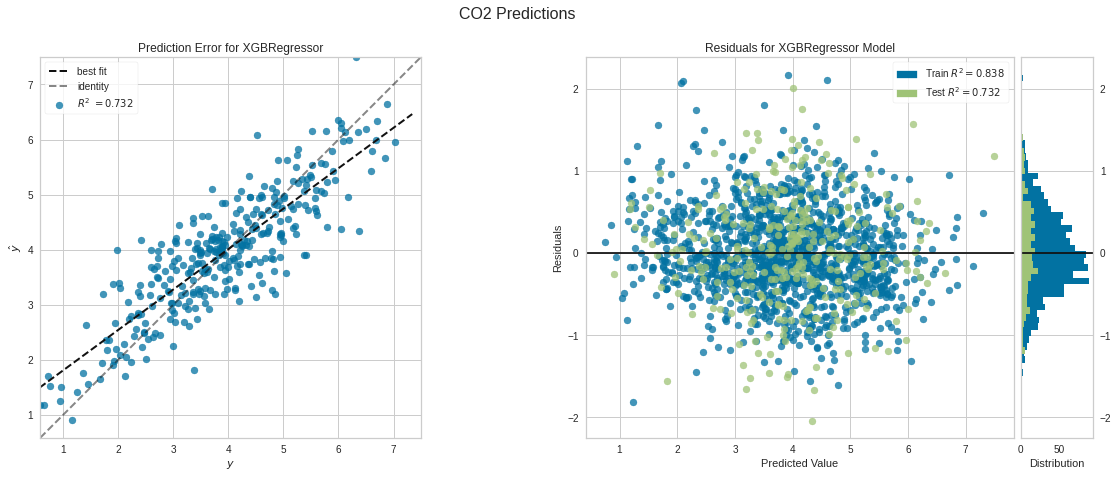

In [19]:
from yellowbrick.regressor import PredictionError, ResidualsPlot

fig, axes = plt.subplots(1, 2, figsize=(20,7))
visualgrid = [
    PredictionError(tuned_model_co2, ax=axes[0]),
    ResidualsPlot(tuned_model_co2, ax=axes[1])
]
for viz in visualgrid:
    viz.fit(X_train, y_train_log_co2)
    viz.score(X_test, y_test_log_co2)
    viz.finalize()
fig.suptitle('CO2 Predictions', fontsize=16)
plt.show()

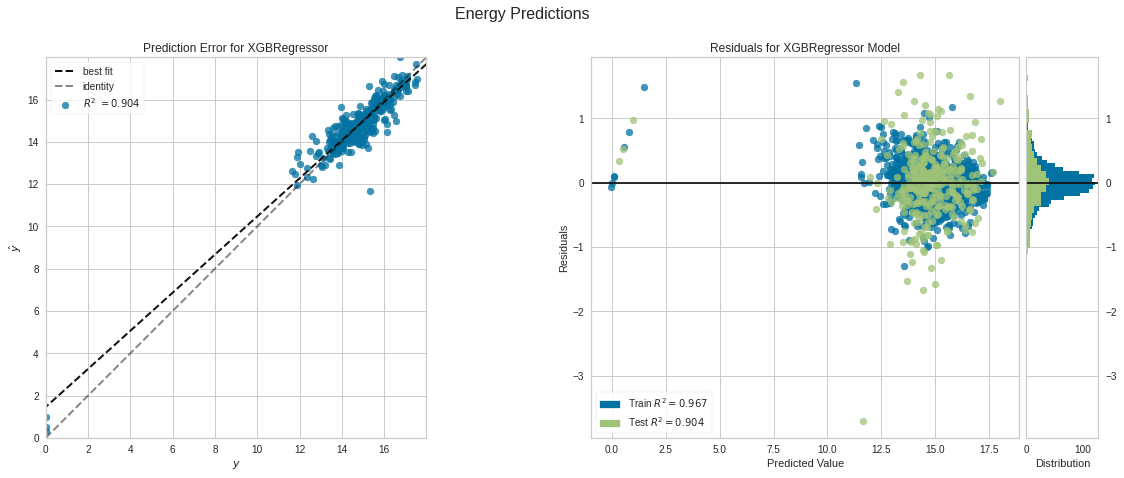

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(20,7))
visualgrid = [
    PredictionError(tuned_model_nrg, ax=axes[0]),
    ResidualsPlot(tuned_model_nrg, ax=axes[1])
]
for viz in visualgrid:
    viz.fit(X_train, y_train_log_nrg)
    viz.score(X_test, y_test_log_nrg)
    viz.finalize()
fig.suptitle('Energy Predictions', fontsize=16)
plt.show()

#### Predictions by building type

In [54]:
# Breaks down the test df according to the building types

sliced_preds = {}
buildingType_cols = [col for col in train.columns if 'BuildingType' in col]
used_idx = []
for buildtype in buildingType_cols:
    idx = list(X_test[X_test[buildtype] != 0.].index)
    if not idx:
        continue
    used_idx.extend(idx)
    # get bt preds
    partial_preds_co2 = preds_co2.loc[idx]
    partial_preds_nrg = preds_nrg.loc[idx]
    # get bt true values
    partial_true_co2 = y_test_log_co2.reset_index(drop=True).loc[idx]
    partial_true_nrg = y_test_log_nrg.reset_index(drop=True).loc[idx]
    # compute R²
    partial_score_co2 = metrics.r2_score(partial_true_co2, partial_preds_co2)
    partial_score_nrg = metrics.r2_score(partial_true_nrg, partial_preds_nrg)
    # store scores
    sliced_preds[buildtype] = (partial_score_co2, partial_score_nrg)
    print(f"{buildtype}: {len(idx)} rows\n- co2: {partial_score_co2}\n- energy: {partial_score_nrg}\n")

# a categ was removed to avoid perfectly collinear features

# search last building type
last_type = ""
for bt in data.BuildingType.unique():
    if "BuildingType_" + bt not in buildingType_cols:
        last_type = "BuildingType_" + bt
# get last type index
last_type_idx = X_test[~X_test.index.isin(used_idx)].index.to_list()
if last_type_idx:
    # get last type preds
    partial_preds_co2 = preds_co2.loc[last_type_idx]
    partial_preds_nrg = preds_nrg.loc[last_type_idx]
    # get last type y
    partial_y_co2 = y_test_log_co2.reset_index(drop=True).loc[last_type_idx]
    partial_y_nrg = y_test_log_nrg.reset_index(drop=True).loc[last_type_idx]
    # compute R²
    partial_score_co2 = metrics.r2_score(partial_y_co2, partial_preds_co2)
    partial_score_nrg = metrics.r2_score(partial_y_nrg, partial_preds_nrg)
    # store score
    sliced_preds[last_type] = (partial_score_co2, partial_score_nrg)
    print(f"{last_type}: {len(last_type_idx)} rows\n- co2: {partial_score_co2}\n- energy: {partial_score_nrg}")

BuildingType_nonresidential: 284 rows
- co2: 0.6887482478982148
- energy: 0.7022032403769205

BuildingType_nonresidential cos: 17 rows
- co2: 0.732767387638001
- energy: 0.6437574196471649

BuildingType_sps-district k-12: 19 rows
- co2: 0.6226957930408523
- energy: 0.998634203633199

BuildingType_campus: 3 rows
- co2: 0.5889929790706004
- energy: 0.8384173070098642


In [55]:
fig = go.Figure([
    go.Bar(x=list(sliced_preds.keys()),
           y=[sliced_preds[x][0] for x in sliced_preds],
           text=[f"{sliced_preds[x][0]:.3f}"for x in sliced_preds],
           marker_color='#B6DEDD', name='CO2'),
    go.Bar(x=list(sliced_preds.keys()),
           y=[sliced_preds[x][1] for x in sliced_preds],
           text=[f"{sliced_preds[x][1]:.3f}" for x in sliced_preds],
           marker_color='#FFE072', name='Energy')
])
fig.update_layout(width=700, height=500,
                  title="R² on testset by Building Type",
                  yaxis_title="R²", **plotly_base_params)
fig.show()

### Feature importance

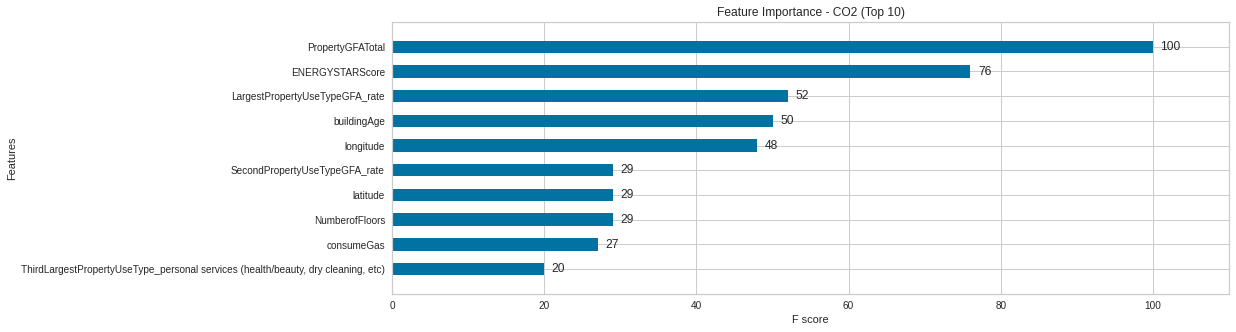

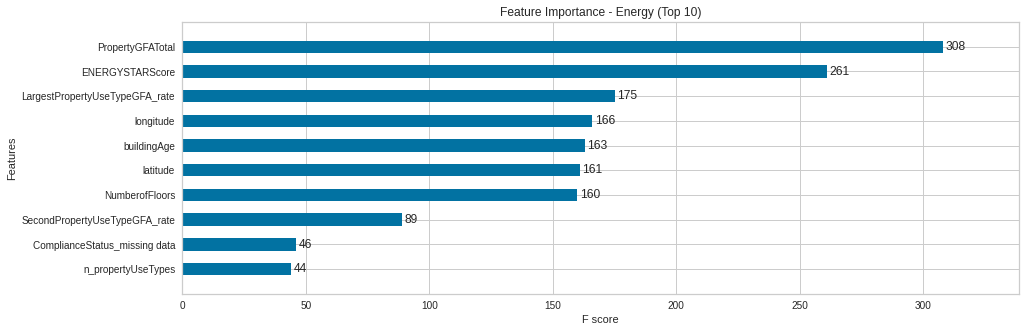

In [56]:
n_features_display = 10

for k, model in tuned_models.items():
    fig, ax = plt.subplots(figsize=(15, 5), facecolor='white')
    plot_importance(
        model, ax=ax,
        height=.5, grid=True,
        max_num_features=n_features_display,
        title=f"Feature Importance - {k} (Top {n_features_display})",
    )
    ax.set_facecolor("white")
    plt.show()
    print()

Unfortunately it's possible to see that this is one of the most important feature for both models.

The EnergyStar score is an expensive value to compute. We need to determine its importance for predictions and look for a model that performs well without this column. The project owner can then decide whether to continue calculating this value or not.

## Without EnergyStar Score

### Search new model

In [21]:
X_train_v2 = X_train.drop(columns=['ENERGYSTARScore'])
X_test_v2 = X_test.drop(columns=['ENERGYSTARScore'])

In [22]:
co2_scores_v2 = compare_models_cv(X_train_v2, y_train_log_co2, models, cv, eval, verbose=1)
co2_scores_v2['test_neg_root_mean_squared_error'] = co2_scores_v2['test_neg_root_mean_squared_error'] * -1
co2_scores_v2['train_neg_root_mean_squared_error'] = co2_scores_v2['train_neg_root_mean_squared_error'] * -1
co2_scores_v2

Training Ridge ... Done ✅
Training Lasso ... Done ✅
Training Elasticnet ... Done ✅
Training LinearSVR ... Done ✅
Training SVR ... Done ✅
Training RandomForest ... Done ✅
Training XGBoost ... Done ✅
Training MLP ... Done ✅


,fit_time,score_time,test_neg_root_mean_squared_error,train_neg_root_mean_squared_error,test_r2,train_r2
model,,,,,,
Ridge,0.028,0.010,0.866,0.758,0.575,0.678
Lasso,0.021,0.009,1.333,1.334,-0.002,0.000
Elasticnet,0.020,0.011,1.333,1.334,-0.002,0.000
LinearSVR,0.037,0.006,0.878,0.775,0.562,0.662
SVR,0.157,0.036,0.879,0.756,0.562,0.679
RandomForest,1.567,0.027,0.801,0.300,0.635,0.949
XGBoost,0.742,0.006,0.759,0.634,0.673,0.774
MLP,25.906,0.013,0.909,0.391,0.528,0.914


In [23]:
nrg_scores_v2 = compare_models_cv(X_train_v2, y_train_log_nrg, models, cv, eval, verbose=1)
nrg_scores_v2['test_neg_root_mean_squared_error'] = nrg_scores_v2['test_neg_root_mean_squared_error'] * -1
nrg_scores_v2['train_neg_root_mean_squared_error'] = nrg_scores_v2['train_neg_root_mean_squared_error'] * -1
nrg_scores_v2

Training Ridge ... Done ✅
Training Lasso ... Done ✅
Training Elasticnet ... Done ✅
Training LinearSVR ... Done ✅
Training SVR ... Done ✅
Training RandomForest ... Done ✅
Training XGBoost ... Done ✅
Training MLP ... Done ✅


,fit_time,score_time,test_neg_root_mean_squared_error,train_neg_root_mean_squared_error,test_r2,train_r2
model,,,,,,
Ridge,0.027,0.011,0.935,0.812,0.621,0.742
Lasso,0.021,0.011,1.562,1.600,-0.006,0.000
Elasticnet,0.017,0.009,1.562,1.600,-0.006,0.000
LinearSVR,0.038,0.007,1.124,1.081,0.491,0.544
SVR,0.154,0.034,1.238,1.220,0.392,0.419
RandomForest,1.497,0.028,0.879,0.370,0.663,0.946
XGBoost,0.675,0.007,0.844,0.590,0.689,0.864
MLP,36.943,0.009,1.067,0.388,0.499,0.941


In [24]:
x = list(models.keys())
train_clr = '#FF8019'
test_clr = '#2DB42D'
time_clr = '#5CA3F9'

# chart
fig = make_subplots(
    rows=3, cols=2,
    column_widths=[0.5, 0.5],
    horizontal_spacing=0.2, vertical_spacing=0.05,
    specs=[[{"type": "bar"}, {"type": "bar"}],
           [{"type": "bar"}, {"type": "bar"}],
           [{"type": "bar"}, {"type": "bar"}]],
           subplot_titles=("CO2 Emissions", "Energy Consumption")
)
# R2
fig.add_trace(go.Bar(x=list(models.keys()), y=co2_scores_v2.train_r2, marker_color=train_clr, name='train'), row=1, col=1)
fig.add_trace(go.Bar(x=list(models.keys()), y=co2_scores_v2.test_r2, marker_color=test_clr, name='test'),  row=1, col=1)
fig.add_trace(go.Bar(x=list(models.keys()), y=nrg_scores_v2.train_r2, marker_color=train_clr, name='train'), row=1, col=2)
fig.add_trace(go.Bar(x=list(models.keys()), y=nrg_scores_v2.test_r2, marker_color=test_clr, name='test'),  row=1, col=2)
# RMSE
fig.add_trace(go.Bar(x=list(models.keys()), y=co2_scores_v2.train_neg_root_mean_squared_error, marker_color=train_clr, name='train'), row=2, col=1)
fig.add_trace(go.Bar(x=list(models.keys()), y=co2_scores_v2.test_neg_root_mean_squared_error, marker_color=test_clr, name='test'),  row=2, col=1)
fig.add_trace(go.Bar(x=list(models.keys()), y=nrg_scores_v2.train_neg_root_mean_squared_error, marker_color=train_clr, name='train'), row=2, col=2)
fig.add_trace(go.Bar(x=list(models.keys()), y=nrg_scores_v2.test_neg_root_mean_squared_error, marker_color=test_clr, name='test'),  row=2, col=2)

# fit time
fig.add_trace(go.Bar(x=list(models.keys()), y=co2_scores_v2.fit_time, marker_color=time_clr), row=3, col=1)
fig.add_trace(go.Bar(x=list(models.keys()), y=nrg_scores_v2.fit_time, marker_color=time_clr), row=3, col=2)


# styling
fig.update_traces(texttemplate='%{y:.2f}', textposition='inside')
fig['layout']['yaxis']['title']='<b>R²</b>'
fig['layout']['yaxis3']['title']='<b>RMSE</b>'
fig['layout']['yaxis5']['title']='<b>Fit Time</b>'
fig.for_each_annotation(lambda a: a.update(text=f'<b>{a.text}</b>'))
fig.update_layout(width=1000, height=1000, barmode='group', title="Models Cross-Validation Comparisons", showlegend=False, **plotly_base_params)
fig.show()

In [25]:
%%time
from sklearn.model_selection import GridSearchCV
import joblib

xgb_params_grid = {
    'n_estimators' : [150, 200, 300],
    'max_depth': [3, 5, 7, 9],
    'colsample_bytree': [.2, .4, .6, .8],
    'subsample': [.5, .7, .9],
    'learning_rate': [.1, .01]
}
fixed_params_co2 = {
    #'learning_rate': 0.1,
    #'max_depth': 2,
    #'colsample_bytree': 0.2,
    #'subsample': .8
}

model_co2_v2 = XGBRegressor(**fixed_params_co2, objective='reg:squarederror', n_jobs=-1, random_state=SEED)
gs_co2_v2 = GridSearchCV(model_co2_v2, xgb_params_grid, cv=cv, scoring='r2', return_train_score=True, n_jobs=-1)
gs_co2_v2.fit(X_train_v2, y_train_log_co2)
joblib.dump(gs_co2_v2.best_estimator_, os.path.join(MODELS_DIR, "tuned_xgb_co2_v2.pkl"))
print(f"CO2 emissions:\n > Best r²: {gs_co2_v2.best_score_}\n > Best params: {gs_co2_v2.best_params_}")
tuned_model_co2_v2 = gs_co2_v2.best_estimator_

CO2 emissions:
 > Best r²: 0.6766733912440736
 > Best params: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.9}
CPU times: user 24.3 s, sys: 2 s, total: 26.3 s
Wall time: 58min 56s


In [26]:
%%time
xgb_params_grid = {
    'n_estimators' : [150, 200, 250],
    'max_depth': [1, 3, 5, 7, 9],
    'colsample_bytree': [.6, .7, .8],
    'subsample': [.4, .6, .8, .9],
    #'learning_rate': [.001, .01, 0.1]
}
fixed_params_nrg = {
    #'n_estimator':100,
    #'learning_rate': 0.1,
    #'max_depth': 7,
    #'subsample': .8,
    #'colsample_bytree': .8,
}

model_nrg_v2 = XGBRegressor(**fixed_params_nrg, objective='reg:squarederror', n_jobs=-1, random_state=SEED)
gs_nrg_v2 = GridSearchCV(model_nrg_v2, xgb_params_grid, cv=cv, scoring='r2', return_train_score=True, n_jobs=-1)
gs_nrg_v2.fit(X_train_v2, y_train_log_nrg)
joblib.dump(gs_nrg_v2.best_estimator_, os.path.join(MODELS_DIR, "tuned_xgb_nrg_v2.pkl"))
print(f"Energy consumption:\n > Best r²: {gs_nrg_v2.best_score_}\n > Best params: {gs_nrg_v2.best_params_}")
tuned_model_nrg_v2 = gs_nrg_v2.best_estimator_

Energy consumption:
 > Best r²: 0.6992103407185776
 > Best params: {'colsample_bytree': 0.6, 'max_depth': 3, 'n_estimators': 250, 'subsample': 0.9}
CPU times: user 17.1 s, sys: 1.24 s, total: 18.4 s
Wall time: 36min 22s


In [27]:
# Loads models if the environment has restarted
if not 'tuned_model_co2_v2' in locals():
    tuned_model_co2_v2 = joblib.load(os.path.join(MODELS_DIR, f"tuned_xgb_co2_v2.pkl"))
    print('✅ CO2 model loaded.')
if not 'tuned_model_nrg_v2' in locals():
    tuned_model_nrg_v2 = joblib.load(os.path.join(MODELS_DIR, f"tuned_xgb_nrg_v2.pkl"))
    print('✅ Energy model loaded.')

In [28]:
preds_co2_v2 = pd.DataFrame(tuned_model_co2_v2.predict(X_test_v2))
score_co2_v2 = metrics.r2_score(y_test_log_co2, preds_co2_v2)

print(f"Scores CO2 without EnergyStarScore - train R²={score_co2_v2:.3f} / test R²={score_co2_v2:.3f}")

preds_nrg_v2 = pd.DataFrame(tuned_model_nrg_v2.predict(X_test_v2))
score_nrg_v2 = metrics.r2_score(y_test_log_nrg, preds_nrg_v2)

print(f"Scores Energy without EnergyStarScore - train R²={score_nrg_v2:.3f} / test R²={score_nrg_v2:.3f}")

Scores CO2 without EnergyStarScore - train R²=0.693 / test R²=0.693
Scores Energy without EnergyStarScore - train R²=0.889 / test R²=0.889


### Comparisons

In [29]:
fig = go.Figure([
    go.Bar(x=['CO2', 'Energy'],
           y=[score_co2['test'], score_nrg['test']],
           marker_color='#65cbd6', name='V1: With EnergyStarScore'),
    go.Bar(x=['CO2', 'Energy'],
           y=[score_co2_v2, score_nrg_v2],
           marker_color='#a0db53', name='V2: Without EnergyStarScore')
])
fig.update_traces(texttemplate='%{y:.3f}', textposition='inside')
fig.update_layout(width=600, height=400,
                  title="Tuned XGB model",
                  yaxis_title="R²", **plotly_base_params)
fig.show()

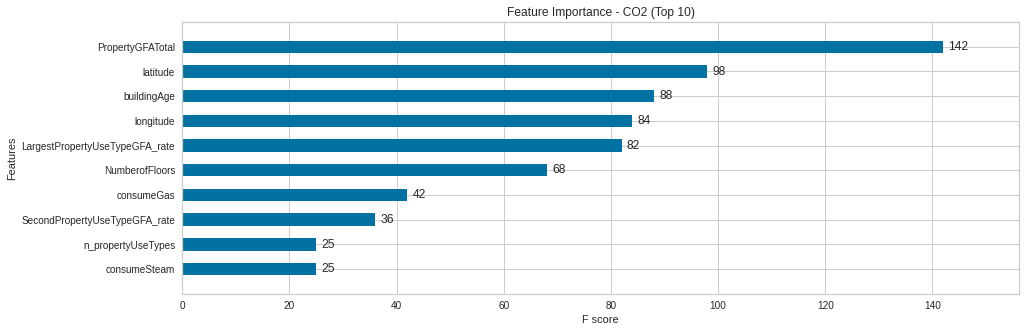

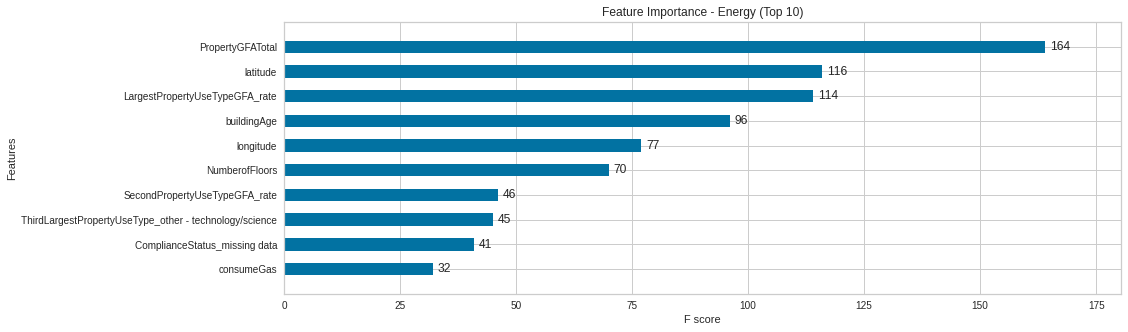

In [30]:
n_features_display = 10

for k, model in dict(CO2=tuned_model_co2_v2, Energy=tuned_model_nrg_v2).items():
    fig, ax = plt.subplots(figsize=(15, 5), facecolor='white')
    plot_importance(
        model, ax=ax,
        height=.5, grid=True,
        max_num_features=n_features_display,
        title=f"Feature Importance - {k} (Top {n_features_display})",
    )
    ax.set_facecolor("white")
    plt.show()
    print()